In [1]:
! pip install transformers
! pip install pycaret

  Obtaining dependency information for pycaret from https://files.pythonhosted.org/packages/eb/43/ec8d59a663e0a1a67196b404ec38ccb0051708bad74a48c80d96c61dd0e5/pycaret-3.2.0-py3-none-any.whl.metadata
  Using cached pycaret-3.2.0-py3-none-any.whl.metadata (17 kB)
  Obtaining dependency information for category-encoders>=2.4.0 from https://files.pythonhosted.org/packages/7f/e5/79a62e5c9c9ddbfa9ff5222240d408c1eeea4e38741a0dc8343edc7ef1ec/category_encoders-2.6.3-py2.py3-none-any.whl.metadata
  Using cached category_encoders-2.6.3-py2.py3-none-any.whl.metadata (8.0 kB)
  Obtaining dependency information for lightgbm>=3.0.0 from https://files.pythonhosted.org/packages/b3/f8/ee33e36194eb03a76eccf3adac3fba51f0e56fbd20609bb531659d48d3cb/lightgbm-4.1.0-py3-none-win_amd64.whl.metadata
  Using cached lightgbm-4.1.0-py3-none-win_amd64.whl.metadata (19 kB)
  Using cached matplotlib-3.6.0-cp311-cp311-win_amd64.whl (7.2 MB)
  Obtaining dependency information for plotly-resampler>=0.8.3.1 from https://f

In [6]:
!pip install  torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/d6/a8/43e5033f9b2f727c158456e0720f870030ad3685c46f41ca3ca901b54922/torch-2.1.1-cp311-cp311-win_amd64.whl.metadata
  Using cached torch-2.1.1-cp311-cp311-win_amd64.whl.metadata (26 kB)
   ---------------------------------------- 0.0/192.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/192.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/192.3 MB 162.5 kB/s eta 0:19:44
   ---------------------------------------- 0.0/192.3 MB 186.2 kB/s eta 0:17:13
   ---------------------------------------- 0.1/192.3 MB 297.7 kB/s eta 0:10:46
   ---------------------------------------- 0.1/192.3 MB 374.1 kB/s eta 0:08:34
   ---------------------------------------- 0.1/192.3 MB 532.5 kB/s eta 0:06:01
   ---------------------------------------- 0.2/192.3 MB 621.6 kB/s eta 0:05:10
   ---------------------------------------- 0.3/192.3 MB 682.7 kB/s eta 0:04:42
   ---------------------

In [1]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
from transformers import AutoModel


In [2]:
device = torch.device("cuda")


([<matplotlib.patches.Wedge at 0x29b525d2210>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

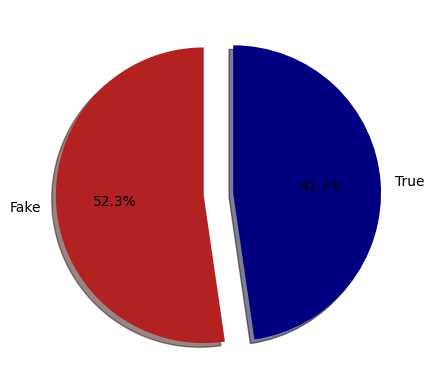

In [2]:
# Load Dataset
true_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv')

# Generate labels True/Fake under new Target Column in 'true_data' and 'fake_data'
true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

# Merge 'true_data' and 'fake_data', by random mixing into a single df called 'data'
data = true_data.append(fake_data).sample(frac=1).reset_index().drop(columns=['index'])

# Target column is made of string values True/Fake, let's change it to numbers 0/1 (Fake=1) 
data['label'] = pd.get_dummies(data.Target)['Fake']


# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

In [3]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [4]:

# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')



Text(0, 0.5, 'Number of texts')

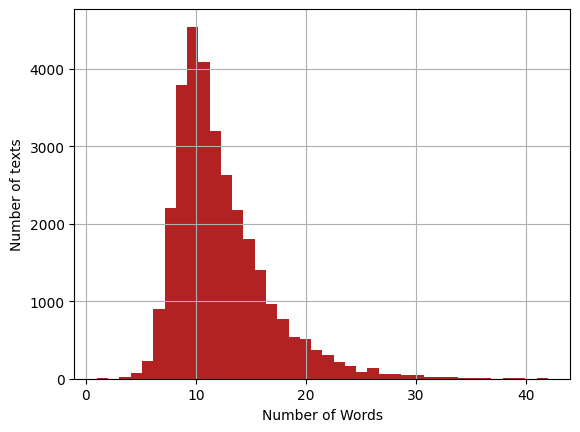

In [5]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]
pd.Series(seq_len).hist(bins = 40,color='firebrick')

plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [6]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGHT = 15
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size
train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

In [7]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [11]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x
model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 1

In [12]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

In [14]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 1
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.501
Validation Loss: 0.441


In [15]:
# load weights of best model
path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()
  
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82      3212
           1       0.90      0.72      0.80      3523

    accuracy                           0.81      6735
   macro avg       0.82      0.81      0.81      6735
weighted avg       0.83      0.81      0.81      6735



In [16]:
# testing on unseen data
news = pd.read_csv('News_2010_2023.csv')


In [17]:
# new = news.head()
# new['content']
news = news.dropna(subset=['title'])


In [60]:
# x = news.head(4)['content']
# x = news.iloc[3]['content']
content_list = news['title'].tolist()
content_list[:5]

['2009: The year in movies',
 'A late night stroll around a Paris department store',
 'Universities, the heart of Iranian opposition',
 'Dakar Rally kicks off an ocean away',
 'Iraq murder charges against five Blackwater security guards are dismissed']

In [62]:

unseen_news_text = ["maradona played in argentina","maradona played in england","Breaking: Penguins Now Found Roaming the Streets of New York Cit","A fabricated story claims that NASA has predicted a rare celestial event that will plunge the Earth into complete darkness for 48 hours in December. "]
# unseen_news_text = ["Former President Donald Trump Announces New Political Action Committee"]
# unseen_news_text = ["Legal Battles Continue: Trump Challenges Election Results in Court"]
# unseen_news_text = content_list[:5]
# tokenize and encode sequences in the test set
MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
preds

array([0, 1, 1, 1], dtype=int64)

In [49]:
# plt.figure(figsize=(10, 6))
# plt.plot(train_losses, label='Training Loss', marker='o')
# plt.plot(valid_losses, label='Validation Loss', marker='o')
# plt.title('Training and Validation Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

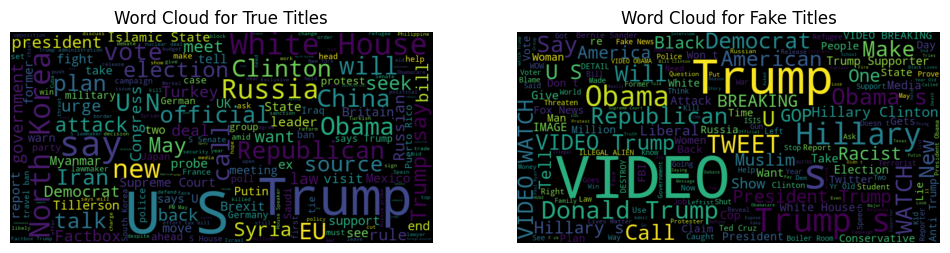

In [50]:
from wordcloud import WordCloud

# Extract true and fake titles
true_titles = data[data['Target'] == 'True']['title']
fake_titles = data[data['Target'] == 'Fake']['title']

# Generate Word Cloud for True Titles
wordcloud_true = WordCloud(width = 800, height = 400, random_state=21, max_font_size=110).generate(' '.join(true_titles))

# Generate Word Cloud for Fake Titles
wordcloud_fake = WordCloud(width = 800, height = 400, random_state=21, max_font_size=110).generate(' '.join(fake_titles))

# Plot Word Clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.title('Word Cloud for True Titles')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Word Cloud for Fake Titles')
plt.axis('off')

plt.show()


In [128]:
!pip install wordcloud

  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/f5/b0/247159f61c5d5d6647171bef84430b7efad4db504f0229674024f3a4f7f2/wordcloud-1.9.3-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   ---------------------------------------- 0.0/300.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.2 kB ? eta -:--:--
   --- ----------------------------------- 30.7/300.2 kB 435.7 kB/s eta 0:00:01
   ------- ------------------------------- 61.4/300.2 kB 469.7 kB/s eta 0:00:01
   -------------- ----------------------- 112.6/300.2 kB 595.3 kB/s eta 0:00:01
   ---------------------- --------------- 174.1/300.2 kB 748.1 kB/s eta 0:00:01
   ------------------------------- ------ 245.8/300.2 kB 885.4 kB/s eta 0:00:01
   -------------------------------------  297.0/300.2 kB 965.4 kB/s eta 0:00:01
   -------------------------------------  297.0/300.2 kB 965.4 kB/s eta 0:00:01
   -----------

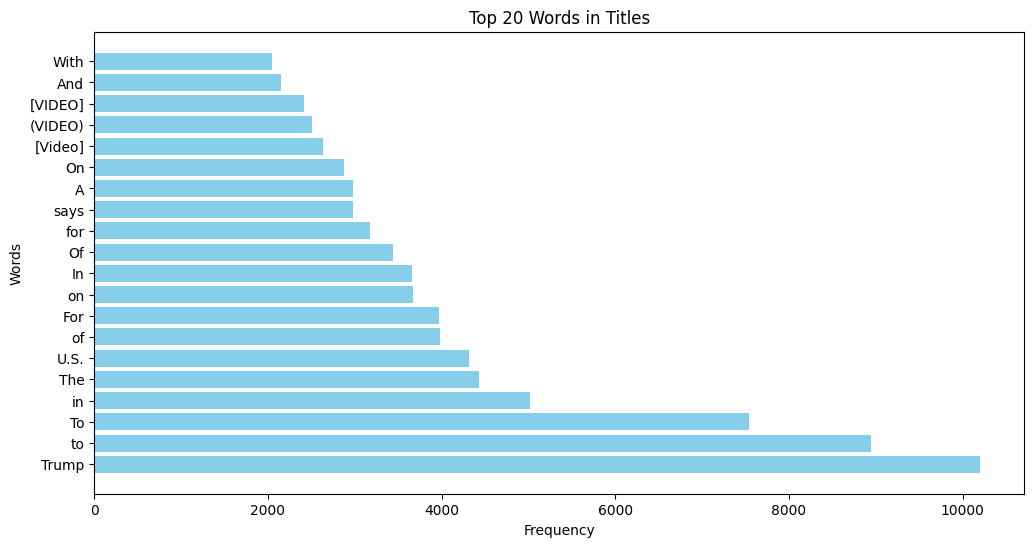

In [51]:
from collections import Counter

# Tokenize all titles and count word frequency
all_titles = ' '.join(data['title'])
word_counts = Counter(all_titles.split())

# Plot the top N words by frequency
N = 20
common_words = [word[0] for word in word_counts.most_common(N)]
word_freq = [word_counts[word] for word in common_words]

plt.figure(figsize=(12, 6))
plt.barh(common_words, word_freq, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top {} Words in Titles'.format(N))
plt.show()


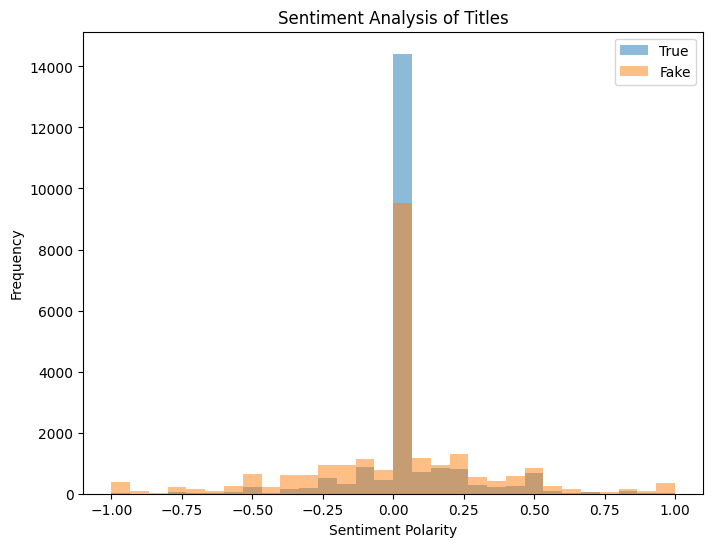

In [143]:
from textblob import TextBlob

# Perform sentiment analysis on titles
data['sentiment'] = data['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(8, 6))
plt.hist(data[data['Target'] == 'True']['sentiment'], bins=30, alpha=0.5, label='True')
plt.hist(data[data['Target'] == 'Fake']['sentiment'], bins=30, alpha=0.5, label='Fake')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis of Titles')
plt.legend()
plt.show()


In [142]:
!pip install textblob

     ---------------------------------------- 0.0/636.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/636.8 kB ? eta -:--:--
      --------------------------------------- 10.2/636.8 kB ? eta -:--:--
      --------------------------------------- 10.2/636.8 kB ? eta -:--:--
     - ----------------------------------- 30.7/636.8 kB 220.2 kB/s eta 0:00:03
     -- ---------------------------------- 41.0/636.8 kB 219.4 kB/s eta 0:00:03
     ---- -------------------------------- 81.9/636.8 kB 353.1 kB/s eta 0:00:02
     --------- -------------------------- 163.8/636.8 kB 614.4 kB/s eta 0:00:01
     ------------- ---------------------- 245.8/636.8 kB 793.0 kB/s eta 0:00:01
     ----------------- ------------------ 317.4/636.8 kB 855.7 kB/s eta 0:00:01
     ----------------------- ------------ 409.6/636.8 kB 983.6 kB/s eta 0:00:01
     ------------------------------- ------ 522.2/636.8 kB 1.1 MB/s eta 0:00:01
     ------------------------------------ - 604.2/636.8 kB 1.2 MB/